In [25]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

In [2]:
vol_img = sitk.ReadImage(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")

file_reader = sitk.ImageFileReader()
file_reader.SetImageIO('NrrdImageIO')
file_reader.SetFileName(r"C:\Users\Audit\Uppsala - Masters Europe\Semester 3\Project in Image analysis - Software\UCAN-PET-CT-image-data-handling-pipeline\Task 2.1\Data\sample3Dimg.nrrd")
file_reader.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000001927AD80060> >

(-0.5, 167.5, 167.5, -0.5)

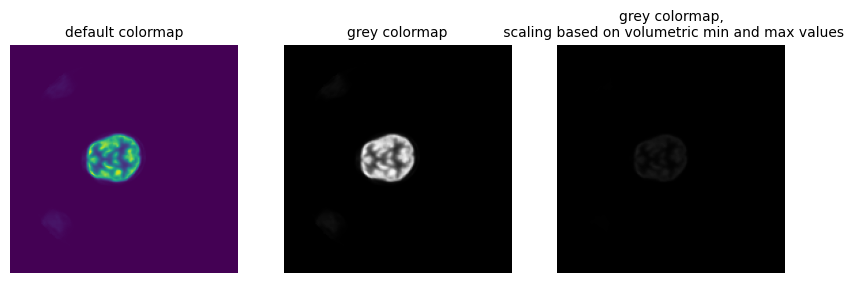

In [5]:
# Display the image slice from the middle of the stack, z axis
# print(vol_img.GetDepth())
z = int(vol_img.GetDepth()/10)
npa_zslice = sitk.GetArrayViewFromImage(vol_img)[z,:,:]
npa = sitk.GetArrayViewFromImage(vol_img)
# Three plots displaying the same data, how do we deal with the high dynamic range?
fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,3,1)
plt.imshow(npa_zslice)
plt.title('default colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,2)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r)
plt.title('grey colormap', fontsize=10)
plt.axis('off')

fig.add_subplot(1,3,3)
plt.title('grey colormap,\n scaling based on volumetric min and max values', fontsize=10)
plt.imshow(npa_zslice,cmap=plt.cm.Greys_r, vmin=npa.min(), vmax=npa.max())
plt.axis('off')

In [24]:
#stik [x,y,z]-> numpy [z,x,y]
nda = sitk.GetArrayFromImage(vol_img)
print(vol_img.GetSize())
print(nda.shape)

nda2d=sitk.GetArrayFromImage(vol_img[:,:,0])
print(nda2d)

(168, 168, 553)
(553, 168, 168)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
# numpy array  -> stik

nda_as_image = sitk.GetImageFromArray(nda)
print(nda_as_image.GetSize())

(168, 168, 553)


In [11]:
# voxel queries

print(vol_img.GetPixelIDValue())
print(vol_img.GetPixelIDTypeAsString())
print(vol_img.GetNumberOfComponentsPerPixel())

9
64-bit float
1


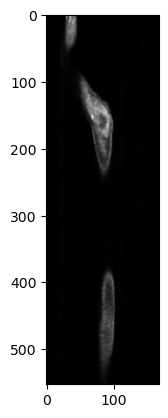

In [46]:
# Accessing and slicing
#help(vol_img.GetPixel)

#slice voxel first

# row z wise slice
# slice_2d=vol_img[:,:,50]
# plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')

# row x wise slice
# slice_2d=vol_img[96,:,:]
# print(type(slice_2d))
# plt.imshow(np.add(sitk.GetArrayFromImage(slice_2d)),cmap='gray')

# row y wise slice
slice_2d=vol_img[:,40,:]
plt.imshow(sitk.GetArrayFromImage(slice_2d),cmap='gray')


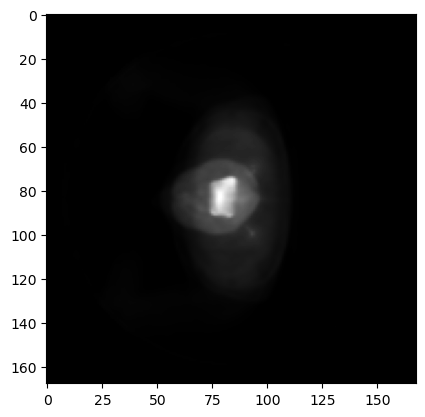

In [28]:
#display img averaged over all pixels

mean_img=np.zeros(nda_as_image.GetSize()[0:2])
for i in range (nda_as_image.GetSize()[-1]):
   mean_img=mean_img+sitk.GetArrayFromImage(vol_img[:,:,i])
mean_img=mean_img/nda_as_image.GetSize()[-1]

plt.imshow(mean_img,cmap='gray')